In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time
import numba

# NOTE: I've included numba "decorators" in the below code, which speed up 
# execution by about a factor of 25x.  To enable it, just uncomment the lines
# that start with
# @numba.jit(nopython=True)

In [96]:
@numba.jit(nopython=True)
def createSystemEnergies(dim, J):
    """
    Create all of the energies for each state in a dim-dimensional Hamming
    cube drawn from a distribution with width J*sqrt(dim)
    """
    E = np.random.normal(loc=0, scale=J*np.sqrt(dim), size=2**dim)
    return E

@numba.jit(nopython=True)
def getNeighbors(site, dim):
    """
    Get the list of all neighbors in the dim-dimensional Hamming cube.
    Note that this function is just provided for testing and shouldn't
    be used in the actual simulation.  Since we're on a Hamming cube each
    neighbor is just a single bit flip away.  We constuct the binary number
    that is all zeros but 1 in the d-th digit by bit shifting 1 d-times.
    This number is then xor-ed with the input site to create a neighbor.
    """
    neighbors = np.zeros(dim, dtype=int)
    for d in range(dim):
        # Compute the exclusive or of site with 1 shifted d times
        neighbors[d] = site ^ (1 << d)
    return neighbors

@numba.jit(nopython=True)
def getRandomNeighbor(site, dim):
    """
    Returns a randomly chosen neighbor.
    """
    return site ^ (1 << np.random.randint(dim))

#@numba.jit(nopython=True)
def REM(dim, T, nSteps, systemEnergies, J=1):
    """
    Run a simple Monte Carlo dynamics on the REM.
    
    args:
        dim (int): The dimension of the Hamming cube
        T (float): The temperature
        nSteps (int): The number of steps in the Monte Carlo
        systemEnergies (np.array of floats of length 2**dim): 
            Optional, the REM energies on the Hamming cube
        J (float): Optional, the parameter J for the width of the
            energies.
    
    returns:
        site (list of ints): The full history of the visited sites
        systemEnergies (np.array of floats of length 2**dim): 
            The REM energies on the Hamming cube
    """
    # systemEnergies = createSystemEnergies(dim, J)
    site = [np.random.randint(2**dim)]
    Energy = []
    for step in range(1,nSteps):
        #Pick a neighbor at random
        proposedSite = getRandomNeighbor(site[-1], dim)
        deltaE = systemEnergies[proposedSite] - systemEnergies[site[-1]]
        if ( deltaE <= 0 ) or ( np.random.rand() < np.exp(-deltaE/T) ):
            site.append(proposedSite)
        else:
            site.append(site[-1])
        Energy.append(systemEnergies[site[step]])
    return site, np.mean(Energy)

#@numba.jit(nopython=True)
def TemperatureSweep(dim, tempList, nSteps, J=1):
    """
    Compute the heat capacity for a range of temperatures.
    
    args:
        dim (int): The dimension of the Hamming cube
        tempList (list of floats): The temperatures to simulate
        nSteps (int): The number of Monte Carlo steps to simulate
        J (float): Optional, the parameter J for the width of the
            energies.
    """
    cV     = []
    Energy = []
    Mag    = []
    Zfunc  = []
    FreeE  = []
    # Use a single realization of the REM for all temperatures
    sysEnergies = createSystemEnergies(dim,J)
    for T in temperature:
        site, e = REM(dim, T, nSteps, sysEnergies, J=J)
        Z = Partition(site, T, sysEnergies)
        E = sysEnergies[site]
        Energy.append(e)
        Zfunc.append(Z)
        FreeE.append(freeEnergy(Z, T))
        # Trim out the first 1/2 of steps to remove the transient
        cV.append(np.var(E[len(E)//2:])/T**2)
        Mag.append(np.mean(Magnetization(site)))
        
    return np.array(cV), np.array(Energy), np.array(Mag), np.array(Zfunc), np.array(FreeE)

#@numba.jit(nopython=True)
def Magnetization(site):
    Magnet = []
    for state in site:
        Mag = 0
        num = bin(state)[2:]
        for i in range(len(num)):
            if int(num[i]) == 1:
                Mag += 1
            elif int(num[i]) == 0:
                Mag -= 1
        Magnet.append(Mag)
    return Magnet

@numba.jit(nopython=True)
def Partition(site, T, sysEnergies):
    energies = []
    for state in site:    
        energies.append(sysEnergies[state])
    return np.sum(np.e**(-(np.array(energies))/T))

@numba.jit(nopython=True)
def freeEnergy(Z, T):
    #print(np.array(-T*np.log(Z)))
    return -T*np.log(Z)

5
6
7
8
9


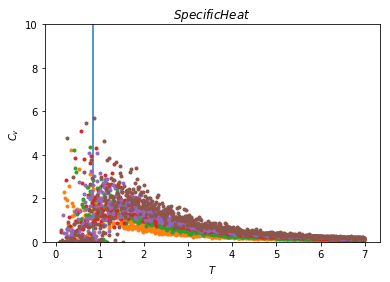

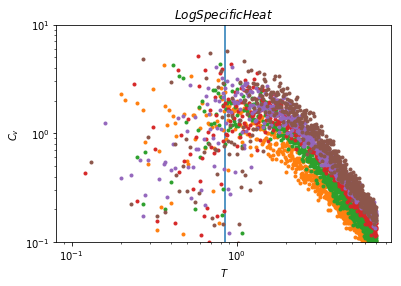

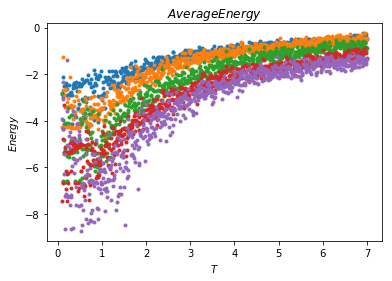

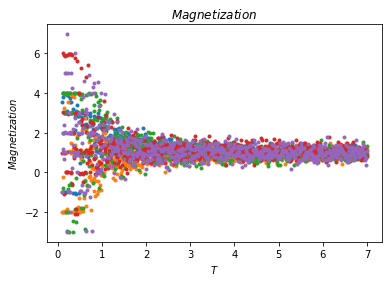

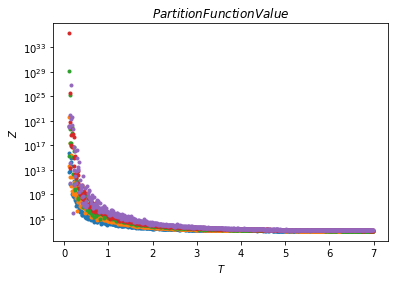

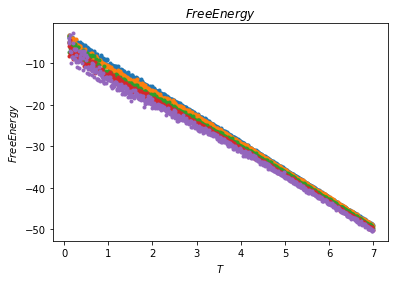

In [99]:
J = 1
nSteps = 1000
T_c = J/np.sqrt(2*np.log(2))
temperature = np.arange(.1, 7, .01)
cV =[]
Energy = []
Magnets = []
ZFunctions = []
FEnergy = []
for dim in range(5,10):
    heat, energy, magnet, Z, free = TemperatureSweep(dim, temperature, nSteps, J=J)
    cV.append(heat)
    Energy.append(energy)
    Magnets.append(magnet)
    ZFunctions.append(Z)
    FEnergy.append(free)
    print(dim)
cV = np.vstack(cV).T
Energy = np.vstack(Energy).T
Magnets = np.vstack(Magnets).T
ZFunctions = np.vstack(ZFunctions).T
FEnergy = np.vstack(FEnergy).T

plt.figure(0)
plt.plot([T_c, T_c], [0,10])
plt.plot(temperature, cV,'.')
plt.ylim([0,10])
plt.xlabel('$T$')
plt.ylabel('$C_v$')
plt.title('$Specific Heat$')

plt.figure(1)
plt.plot([T_c, T_c], [1e-10,10])
plt.loglog(temperature, cV,'.')
plt.ylim([1e-1,10])
plt.xlabel('$T$')
plt.ylabel('$C_v$')
plt.title('$Log Specific Heat$')

plt.figure(2)
plt.plot(temperature, Energy,'.')
plt.xlabel('$T$')
plt.ylabel('$Energy$')
plt.title('$Average Energy$')

plt.figure(3)
plt.plot(temperature, Magnets,'.')
plt.xlabel('$T$')
plt.ylabel('$Magnetization$')
plt.title('$Magnetization$')

plt.figure(4)
plt.semilogy(temperature, ZFunctions, '.')
plt.xlabel('$T$')
plt.ylabel('$Z$')
plt.title('$Partition Function Value$')

plt.figure(5)
plt.plot(temperature, FEnergy, '.')
plt.xlabel('$T$')
plt.ylabel('$Free Energy$')
plt.title('$Free Energy$')